# Notebook to make Figure 8

In [1]:
# Import necessary packages & set-up plotting aesthetics

import numpy as np 
import importlib
import json
import h5ify
import os
import tqdm
import imageio

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from matplotlib import style
style.use('../utils/plotting.mplstyle')
from matplotlib.lines import Line2D

import seaborn as sns
sns.set_palette('coolwarm')

from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list("my_cmap", ['C3','C5', 'C0'])

import sys
sys.path.append('../utils')
import plotting_functions as pf

# where data is saved
data_dir = '../data/different_extrinsic_angles/'

/home/simona.miller/heavy-precessing-bbh-time-domain/figures/../utils/plotting_functions.py:25: SyntaxWarning: invalid escape sequence '\c'
  'chi_eff':'\chi_{\mathrm{eff}}',
/home/simona.miller/heavy-precessing-bbh-time-domain/figures/../utils/plotting_functions.py:26: SyntaxWarning: invalid escape sequence '\c'
  'chi_p':'\chi_p'


### Setup

Load data

In [2]:
# Load in posteriors 
posteriors_dict = h5ify.load(data_dir+'posteriors_different_angles.h5')

# Load in the prior
prior_dict = h5ify.load(data_dir+'../real_and_maxL_GW190521/prior.h5')

# Load in signals' strain 
injection_strain_dict = h5ify.load(data_dir+'waveforms_different_angles.h5')

# Load in the maxL parameters
maxL_params = h5ify.load(data_dir+'../real_and_maxL_GW190521/GW190521_maxL_parameters.h5')

Set up plotting aesthetics

In [3]:
# Parameters to plot
phases = [0.0, 0.3, 0.6, 0.8, 1.0, 1.2, 1.4, 1.7, 2.0, 2.5, 3.0]
psis = ['0.00', '0.15', '0.25', '0.35', '0.50', '0.60', '0.70', '0.75', '0.80', '0.85', '0.90', '0.95']
iotas = [0.0, 0.5, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 3.0]

params_to_plot = {
    'iota':iotas, 
    'pol':psis, 
    'phase':phases,
}

# their latex labels
labels = {
    'phase':r'$\varphi$', 
    'pol':r'$\psi$', 
    'iota':r'$\iota$'
}

# for plotting posteriors
hist_kws = dict(bins=30, density=True, histtype='step')

# cutoff times
cutoff_times = [-0.0381, -0.0254, -0.0127, 0.0]
cutoff_times_M = [-30, -20, -10, 0]

### Make Figure

Make top row

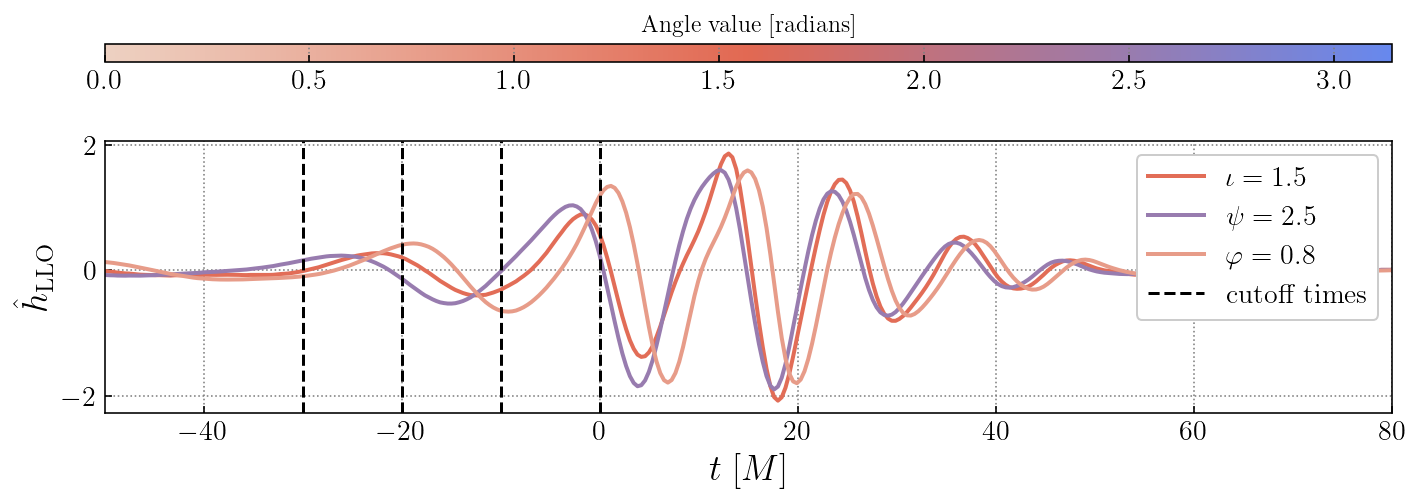

In [5]:
plt.figure(figsize=(pf.DEFAULT_FIG_WIDTH, 2.5))

for k,c,l in zip(['iota 1.5', 'pol 0.80', 'phase 0.8'], 
                 ['k', 'C0', 'C5'], 
                 [r'$\iota = 1.5$', r'$\psi = 2.5$', r'$\varphi = 0.8$']):
    
    p_name, p = k.split(' ')
    c = pf.get_color(p, p_name, cmap)
    
    inj = injection_strain_dict[k]
    
    times = inj['time_dict']['L1'] - maxL_params['L1_time']
    M = maxL_params['mtotal']
    times_M = pf.transform_s_to_M(times, M)

    strain_wh = inj['strain_wh']['L1']

    plt.plot(times_M, strain_wh, lw=2, color=c, label=l)
    
for t in cutoff_times_M: 
    if t==0:
        plt.axvline(t, color='k', ls='--', label='cutoff times')
    else: 
        plt.axvline(t, color='k', ls='--')

plt.legend(loc='upper right', frameon=True, fancybox=True, framealpha=1)
plt.xlabel(r'$t~[M]$')    
plt.ylabel(r'$\hat h_{\rm LLO}$')    
plt.xlim(-50, 80)

cax = plt.axes((0.125, 1.1, 0.775, 0.05)) #(left, bottom, width, height)
cnorm = matplotlib.colors.Normalize(vmin=0, vmax=np.pi)
plt.colorbar(matplotlib.cm.ScalarMappable(norm=cnorm, cmap=cmap), cax=cax, orientation='horizontal')
cax.set_title('Angle value [radians]')

plt.savefig('figure_08a.png', dpi=300, bbox_inches='tight')

plt.show()

Make bottom three rows

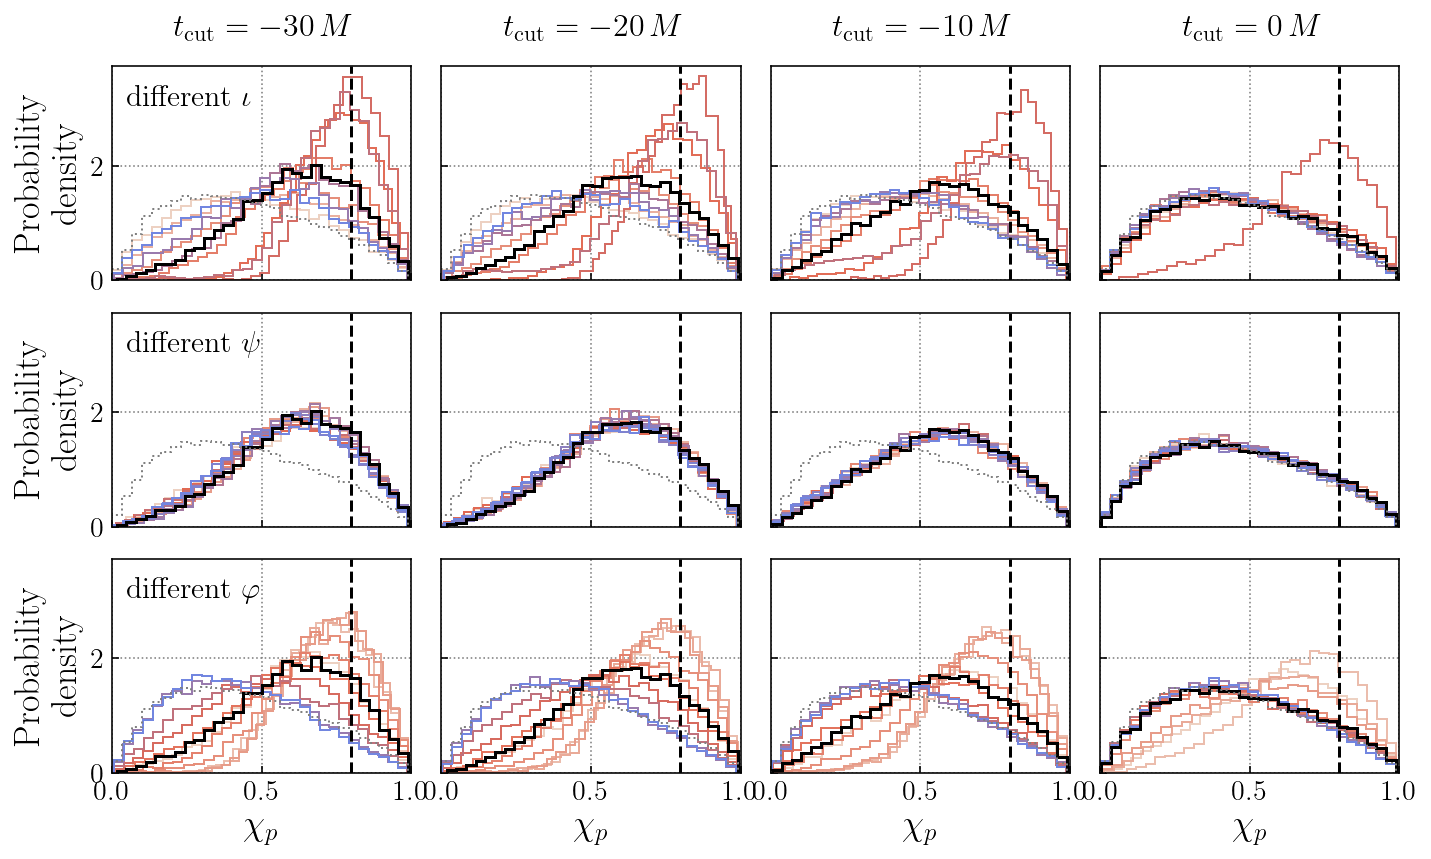

In [7]:
maxL_posterior = posteriors_dict['phase 1.3']

fig, _axes = plt.subplots(nrows=3, ncols=len(cutoff_times), 
                          figsize=(pf.DEFAULT_FIG_WIDTH, 6.5), sharey=True, sharex=True)

# each row is a different varied parameter
for axes, p_name in zip(_axes, params_to_plot): 
    
    # each column is a different cutoff time
    for ax, cutoff in zip(axes, cutoff_times): 
        
        # cycle through each value of the parameter
        for p in params_to_plot[p_name]:
            
            # get from posteriors dict
            posterior = posteriors_dict[f'{p_name} {p}'][f'post {cutoff}seconds']['chi_p_m100M']
            
            # plot 
            ax.hist(posterior, color=pf.get_color(p, p_name, cmap), lw=1, **hist_kws)
            ax.set_xlim(0,1)
            
        # add maxL run posterior
        ax.hist(maxL_posterior[f'post {cutoff}seconds']['chi_p_m100M'], color='k', lw=1.5, **hist_kws)
    
        # add prior
        ax.hist(prior_dict['chi_p_m100M'], color = 'gray', ls=':', lw=1, **hist_kws)
        
        # add injected value 
        ax.axvline(maxL_params['chi_p_m100M'], color='k', ls='--')
        
    axes[0].set_ylabel('Probability\ndensity')
    axes[0].text(0.05, 3.05, f'different {labels[p_name]}', fontsize=15)
            
for ax in _axes[2]: 
    ax.set_xlabel(r'$\chi_p$')
    
for cutoff_M, ax in zip(cutoff_times_M, _axes[0]): 
    ax.set_title(fr'$t_{{\rm cut}} = {cutoff_M} \, M$', fontsize=16, pad=15)
    
plt.subplots_adjust(hspace=0.15, wspace=0.1)
plt.savefig('figure_08b.png', dpi=300, bbox_inches='tight')
plt.show()